### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/ERA5_data/" + x

In [ ]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension
import numpy as np
import dask
# dask.config.set({"array.slicing.split_large_chunks": False})

### We read in the Amaya Coastal Wave Index Amplitude $(\text{Index} =  \sqrt{\text{PC1}^2 + \text{PC2}^2)}$ and Phase $(\text{Phase} = atan( {\frac{\text{PC2}}{\text{PC1}}}))$ and recompute $\text{PC1}$ and $\text{PC2}$. We also remove the leap-year days from the GLORYS dataset.

In [ ]:
#read in Amaya Coastal wave index 
INDEX_TYPE = "SM"
SM_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
SM_Idx["ikw_amp"] = np.sqrt(SM_Idx["PC1"]**2 + SM_Idx["PC2"]**2)

In [ ]:
#read in Amaya Coastal wave index 
INDEX_TYPE = "S"
S_Idx = xr.open_dataset(GLORYS_data_dir("GLORYS_" + INDEX_TYPE + "_Index.nc")).sel(time = slice("1993", "2018"))
S_Idx["ikw_amp"] = np.sqrt(S_Idx["PC1"]**2 + S_Idx["PC2"]**2)

In [ ]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")

In [ ]:
min_amp = 1.0
def is_djfm(month):
    return (month >= 1) & (month <= 3) | (month == 12)
SM_Idx_djf = SM_Idx.isel(time = is_djfm(SM_Idx["time.month"])); min_amp = 1.0
SM_Idx_djf = SM_Idx_djf.isel(time = np.argwhere(SM_Idx_djf.ikw_amp.values > min_amp).flatten())

S_Idx_djf = S_Idx.isel(time = is_djfm(S_Idx["time.month"])); min_amp = 1.0
S_Idx_djf = S_Idx_djf.isel(time = np.argwhere(S_Idx_djf.ikw_amp.values > min_amp).flatten())

In [ ]:
NINO34_ds

<xarray.DataArray (time: 1824)>
array([25.58, 25.57, 26.43, ..., 25.95, 25.78, 25.52])
Coordinates:
  * time     (time) datetime64[ns] 1870-01-15 1870-02-15 ... 2021-12-15

In [176]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1992", "2019"))
NINO34 = normalize(remove_seasonal(NINO34))
NINO34 = NINO34.interp(time = mxtmp_Idx.time.values).sel(time = slice("1993", "2018"))

/tmp/ipykernel_442513/42647970.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  NINO34_ds = xr.DataArray(


[[1.         0.11408936]
 [0.11408936 1.        ]]
[[1.         0.29571732]
 [0.29571732 1.        ]]
[[1.         0.87589041]
 [0.87589041 1.        ]]


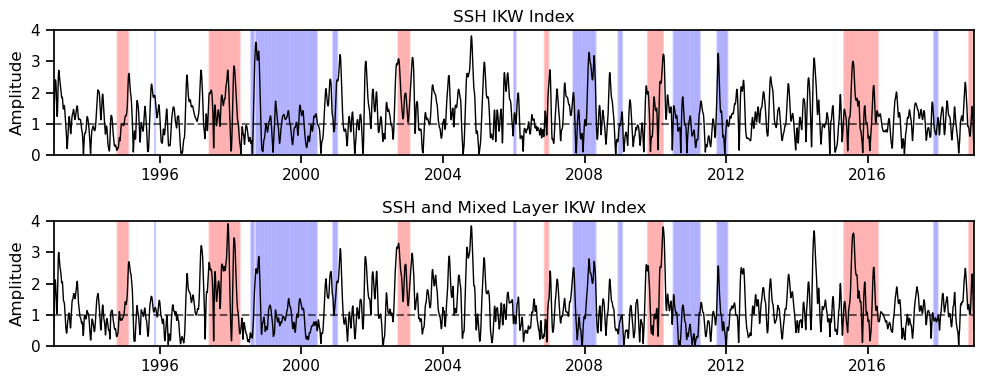

In [187]:
fig, ax = plt.subplots(2, 1, figsize = (10, 4))

ax[0].vlines(NINO34[NINO34 > 1].time, ymin = -3, ymax = 4, color = "red", alpha = 0.2, zorder = 0, linewidth = 0.1)
ax[0].vlines(NINO34[NINO34 < -1].time, ymin = -3, ymax = 4, color = "blue", alpha = 0.2, zorder = 0, linewidth = 0.1)
ax[0].plot(SM_Idx.time, SM_Idx["ikw_amp"], color = "k", linewidth = 1)
ax[0].axhline(1, color = "k", linestyle = "--", alpha = 0.6)
ax[0].set_title("SSH IKW Index")
ax[1].vlines(NINO34[NINO34 > 1].time, ymin = -3, ymax = 4, color = "red", alpha = 0.2, zorder = 0, linewidth = 0.1)
ax[1].vlines(NINO34[NINO34 < -1].time, ymin = -3, ymax = 4, color = "blue", alpha = 0.2, zorder = 0, linewidth = 0.1)
ax[1].plot(S_Idx.time, S_Idx["ikw_amp"], color = "k", linewidth = 1)
ax[1].axhline(1, color = "k", linestyle = "--", alpha = 0.6)
ax[1].set_title("SSH and Mixed Layer IKW Index")
ax[0].set_ylabel("Amplitude")
ax[1].set_ylabel("Amplitude")

print(np.corrcoef(NINO34.values, SM_Idx["ikw_amp"].values))
print(np.corrcoef(NINO34.values, S_Idx["ikw_amp"].values))
print(np.corrcoef(SM_Idx["ikw_amp"], S_Idx["ikw_amp"].values))

for a in ax:
    a.set_ylim(0, 4)
    a.set_xlim(S_Idx.time[0],S_Idx.time[-1])
fig.tight_layout()

In [198]:
print(sum(np.isin(SM_Idx_djf.time, NINO34[np.abs(NINO34) > 1].time)) / len(SM_Idx_djf.time))
print(sum(np.isin(S_Idx_djf.time, NINO34[np.abs(NINO34) > 1].time)) / len(SM_Idx_djf.time))

0.3773283661522086
0.3214475784992017


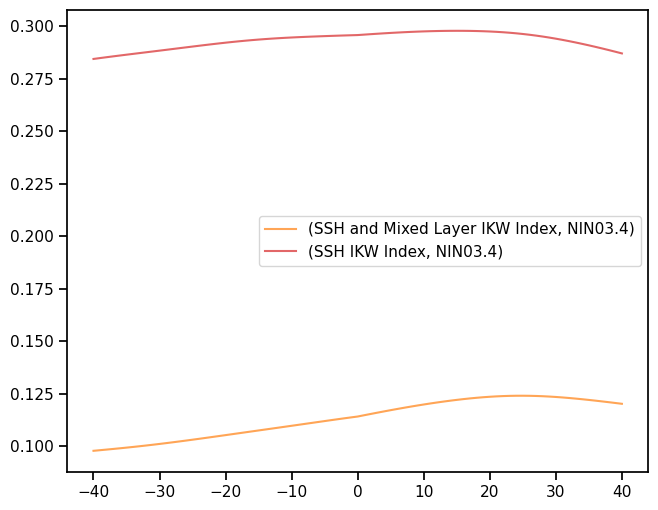

In [204]:
fig, ax = plt.subplots( figsize = (7.5,6));
index_labels = ["(SSH and Mixed Layer IKW Index, NIN03.4)", "(SSH IKW Index, NIN03.4)"]
for (i, idx) in enumerate([SM_Idx["ikw_amp"].values, S_Idx["ikw_amp"].values]):
    output = ax.xcorr(normalize(idx), normalize(NINO34), maxlags=40, usevlines = False, normed=True, alpha=0.0)
    ax.plot(output[0], output[1], label = index_labels[i], alpha = 0.7)
ax.legend()

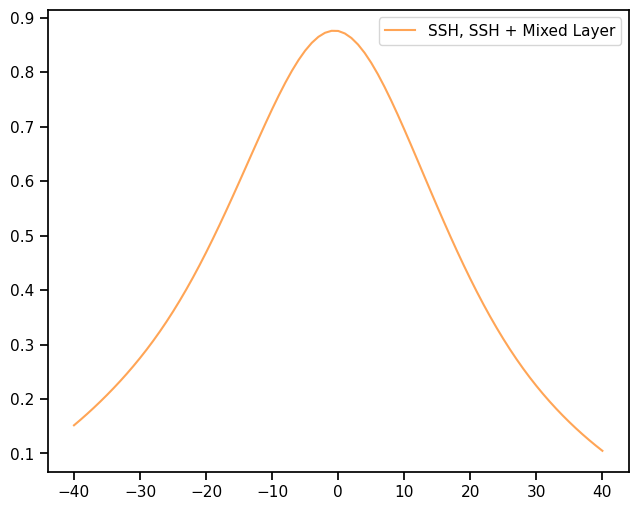

In [205]:
fig, ax = plt.subplots( figsize = (7.5,6));
output = ax.xcorr(normalize(SM_Idx["ikw_amp"].values), normalize(S_Idx["ikw_amp"].values), maxlags=40, usevlines = False, normed=True, alpha=0.0)
ax.plot(output[0], output[1], label = "SSH, SSH + Mixed Layer", alpha = 0.7)
ax.legend()

0.3459286854709952

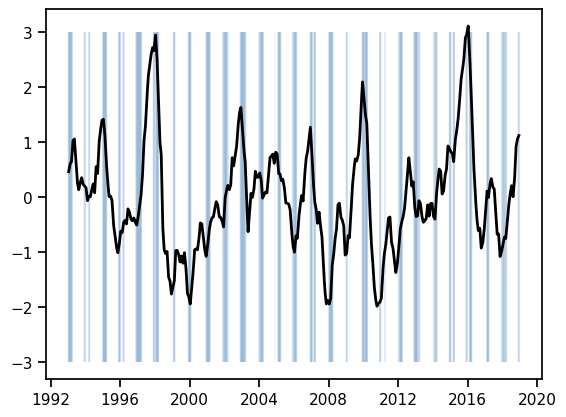

In [127]:
fig, ax = plt.subplots()
ax.vlines(mxtmp_Idx_djf.time, ymin = -3, ymax = 3, label = "SSH Index > 1 (DJFM)", 
          alpha = 0.01, zorder = 0)
ax.plot(NINO34.time, NINO34, color = "k", linewidth = 1)
# ax.set_xlim("1992", "2018")

<xarray.DataArray 'ikw_amp' ()>
array(3.81900412)


(8401.0, 17896.0)

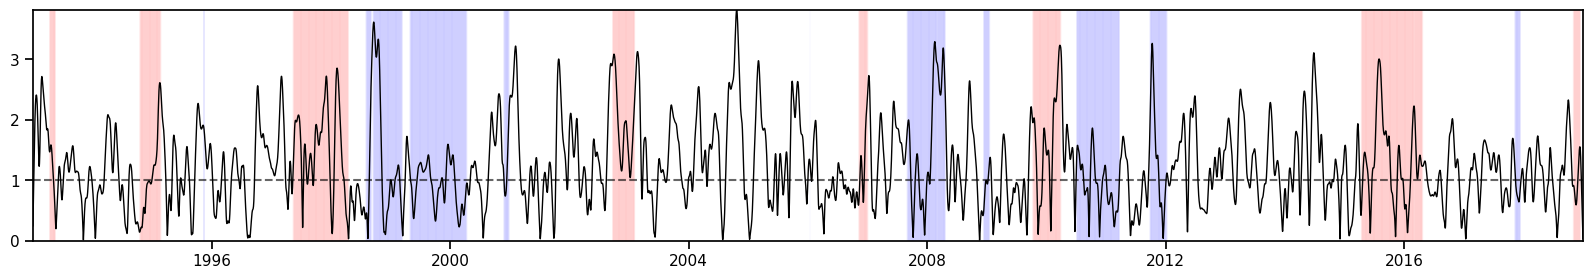

In [133]:
fig, ax = plt.subplots(figsize = (20, 3))
ax.vlines(NINO34[NINO34 > 1].time, ymin = -3, ymax = 4, color = "red", alpha = 0.2, zorder = 0, linewidth = 0.1)
ax.vlines(NINO34[NINO34 < -1].time, ymin = -3, ymax = 4, color = "blue", alpha = 0.2, zorder = 0, linewidth = 0.1)

ax.plot(mxtmp_Idx.time, mxtmp_Idx["ikw_amp"], color = "k", linewidth = 1)
ax.axhline(1, color = "k", linestyle = "--", alpha = 0.6)
print(mxtmp_Idx["ikw_amp"].max())

ax.set_ylim(0, mxtmp_Idx["ikw_amp"].max())
ax.set_xlim(mxtmp_Idx.time[0],mxtmp_Idx.time[-1])